# FORECASTING DE SERIES DE TIEMPO MÚLTIPLE DE DEMANDA INTERMITENTE

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 1. Carga el dataset
df = pd.read_excel('Noel_Test.xlsx')

In [3]:
# 2. Conversión de CODE_MONTH a datetime (día 1 de cada mes)
df['date'] = pd.to_datetime(df['CODE_MONTH'].astype(str), format='%Y%m') + pd.offsets.MonthBegin(0)

In [4]:
# 3. Calcular fecha mínima y máxima con demanda > 0 por serie
first_last = df[df['TOTAL_AMOUNT'] > 0].groupby('PRODUCT_CODE')['date'].agg(first_date='min', last_date='max').reset_index()

In [5]:
# 4. Para cada serie, reindexar solo entre first_date y last_date, rellenar NA con 0
filled = []
for _, row in first_last.iterrows():
    pid = row['PRODUCT_CODE']
    start, end = row['first_date'], row['last_date']
    dr = pd.date_range(start=start, end=end, freq='MS')  # monthly start
    sub = df[df['PRODUCT_CODE'] == pid].set_index('date')
    sub = sub.reindex(dr).rename_axis('date').reset_index()
    sub['PRODUCT_CODE'] = pid
    sub['TOTAL_AMOUNT'] = sub['TOTAL_AMOUNT'].fillna(0)
    filled.append(sub)

df_full = pd.concat(filled, ignore_index=True)

In [6]:
# 5. Pivot “wide” opcional para análisis y modelado
ts_wide = df_full.pivot(index='date', columns='PRODUCT_CODE', values='TOTAL_AMOUNT')

In [ ]:
# 6. EDA: métricas por serie
eda = df_full.groupby('PRODUCT_CODE')['TOTAL_AMOUNT'].agg(
    n_periods='size',
    pct_zeros=lambda x: (x == 0).mean() * 100,
    mean_demand='mean',
    std_demand='std',
    
).reset_index()

In [8]:
# Mostrar la tabla de EDA
print(eda)
#display_dataframe_to_user("Métricas EDA por serie", eda)

     PRODUCT_CODE  n_periods  pct_zeros   mean_demand    std_demand
0           12193         75  37.333333  10912.054267   8965.274436
1           12235         76  51.315789     23.543026     60.200086
2           12383         65  86.153846     37.146062    130.300605
3           12613         67  79.104478    481.429104   1964.303515
4           12806         61  72.131148   5755.803279  12180.865572
..            ...        ...        ...           ...           ...
321         41142          5   0.000000     57.600000     15.388307
322         41143          5   0.000000     58.400000     18.676188
323         41144          5   0.000000     60.000000     12.649111
324         41150          3   0.000000    705.666667    853.816335
325         41151          3   0.000000    709.333333    869.885241

[326 rows x 5 columns]


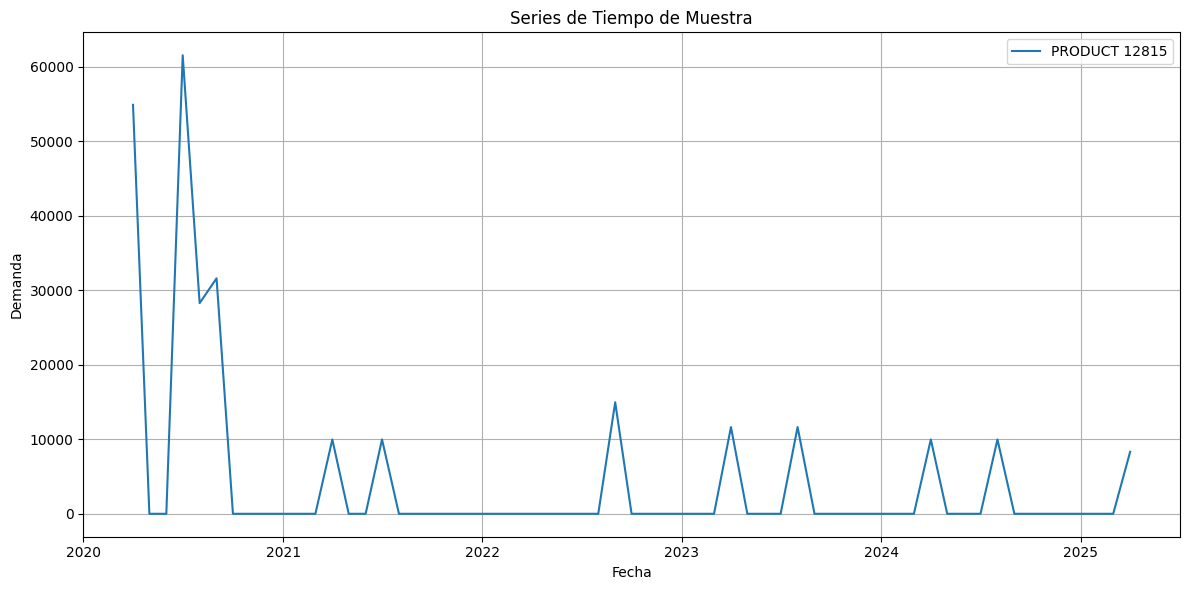

In [24]:
# 7. Visualizar algunas series de muestra
sample_cols = ts_wide.columns.to_list()[9:10]  # toma las primeras 5 series
plt.figure(figsize=(12, 6))
for pid in sample_cols:
    plt.plot(ts_wide.index, ts_wide[pid], label=f'PRODUCT {pid}')
plt.title('Series de Tiempo de Muestra')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [26]:
# 8. Convertir df_full a formato largo ya que ambas librerías (skforecast y statsforecast)
# esperan los datos en formato long: columnas unique_id (serie), ds (fecha), e y (valor).

df_long = (df_full.rename(columns={'date':'ds', 'TOTAL_AMOUNT':'y', 'PRODUCT_CODE':'unique_id'})[['unique_id', 'ds', 'y']])

# Hay que asegurarse de que las fechas estén ordenadas
df_long = df_long.sort_values(['unique_id', 'ds']).reset_index(drop=True)

In [29]:
import pandas as pd
import numpy as np

# Asegúrate de tener la columna 'TOTAL_AMOUNT' como numérica
df_long['unique_id'] = pd.to_numeric(df_long['unique_id'], errors='coerce')

# Función para calcular ADI y CV² por serie temporal
def calc_adi_cv2(x):
    x_nonzero = x[x > 0]
    
    # ADI: total de periodos dividido entre cantidad de demandas no cero
    adi = len(x) / (len(x_nonzero) if len(x_nonzero) > 0 else np.nan)
    
    # CV²: (std / mean)^2, solo sobre demandas no cero
    mean_demand = x_nonzero.mean()
    std_demand = x_nonzero.std()
    cv2 = ((std_demand / mean_demand) ** 2) if mean_demand > 0 else np.nan
    
    return pd.Series({'ADI': adi, 'CV2': cv2})

# Aplicar a cada serie por PRODUCT_CODE
adi_cv2_df = df_long.groupby('unique_id')['y'].apply(calc_adi_cv2).reset_index()

# Mostrar resultados
adi_cv2_df.head()


,unique_id,level_1,y
0,12193,ADI,1.595745
1,12193,CV2,0.044994
2,12235,ADI,2.054054
3,12235,CV2,2.701117
4,12383,ADI,7.222222


In [12]:
# 9. DIVISIÓN TRAIN/TEST
# Para demanda intermitente es habitual dejar las últimas 12-18 observaciones como test (o según estacionalidad).

from sklearn.model_selection import GroupShuffleSplit

In [13]:
# Supongamos que dejamos 6 meses de test por serie:
h = 6

train_list, test_list = [], []
for uid, grp in df_long.groupby('unique_id'):
    train = grp.iloc[:-h].copy()
    test = grp.iloc[-h:].copy()
    train_list.append(train)
    test_list.append(test)

train_long = pd.concat(train_list)
test_long = pd.concat(test_list)

In [14]:
# 10. Benchmark con un forecaster simple (naive)
# Antes de entrar a skforecast/statsforecast, conviene un baseline "naive zero":
# Predicción naive: siempre cero
test_long['y-pred_naive'] = 0

In [ ]:
# 11. Métrica de referencia
# Por ejemplo, SMAPE o MASE (se puede usar sklearn.metrics.mean_absolute_error o tspred.metrics).

In [15]:
import sys
!{sys.executable} -m pip install --upgrade skforecast[all]


^C


In [16]:
import skforecast
print("skforecast version:", skforecast.__version__)


skforecast version: 0.16.0


In [ ]:
# 12. Modelado con skforecast
# Instalación
#%pip install skforecast[all]

# Loop serie a serie
# Usando un modelo autoregresivo con RandomForest (o cualquier regresor):

from skforecast.recursive import ForecasterRecursive
from sklearn.ensemble    import RandomForestRegressor


c:\Users\AlejandroLaderasImpe\Documents\InterForecast\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
resultados_skf = []

for uid, grp in train_long.groupby('unique_id'):
    # define forecaster
    forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(n_estimators = 100, random_state = 42), lags = list(range(1, 13))) # ej lags 1 a 12
    forecaster.fit(y = grp.set_index('ds')['y'])
    # Predicción h pasos
    y_pred = forecaster.predict(steps = h)
    df_pred = pd.DataFrame({'unique_id' : uid, 'ds' : test_long[test_long.unique_id == uid]['ds'].values, 'y_pred_skf' : y_pred})
    resultados_skf.append(df_pred)

pred_skf = pd.concat(resultados_skf)

NameError: name 'ForecasterAutoreg' is not defined

In [17]:
# 13. Modelado con statsforecast (Nixtla)
# Instalación
#%pip install statsforecast

# Definir modelos de demanda intermitente. Por ejemplo: Croston, SBA, TSB:

from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic, CrostonOptimized, CrostonSBA, TSB

In [18]:
# Inicializa la clase
sf = StatsForecast(models = [CrostonClassic(), CrostonOptimized(), CrostonSBA(), TSB()],
                   freq = 'MS',
                   n_jobs = -1)

# Ajusta y pronostica
df_pred_sf = sf.forecast(df = train_long,
                         h = h,
                         level = [80, 95])


TypeError: TSB.__init__() missing 2 required positional arguments: 'alpha_d' and 'alpha_p'

In [19]:
# 14. Evaluación de los Modelos
# Calcula métricas (SMAPE, MAE, MASE) comparando test_long.y con cada predicción:

from sklearn.metrics import mean_absolute_error

In [ ]:
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) /
                   (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100

# Une predicciones
df_eval = test_long.merge(pred_skf, on=['unique_id','ds']) \
                   .merge(df_pred_sf, on=['unique_id','ds'])

# Calcula métricas por modelo
metrics = []
for model in ['y_pred_skf','Croston','SBA','TSB']:
    y_true = df_eval['y']
    y_pred = df_eval[model] if model=='y_pred_skf' else df_eval[f'y_{model}']
    metrics.append({
        'model': model,
        'MAE'  : mean_absolute_error(y_true, y_pred),
        'SMAPE': smape(y_true, y_pred)
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

In [ ]:
# 15. Comparativa y Visualización
# Tabla de métricas
print(metrics_df)

# Gráfica de una serie de ejemplo
uid = df_long['unique_id'].unique()[0]
sub_true = test_long[test_long.unique_id==uid]
sub_preds = df_eval[df_eval.unique_id==uid]

plt.figure(figsize=(10,5))
plt.plot(sub_true.ds, sub_true.y, 'k-', label='Real')
plt.plot(sub_preds.ds, sub_preds.y_pred_skf, '--', label='skforecast RF')
plt.plot(sub_preds.ds, sub_preds.y_Croston,   '--', label='Croston')
plt.plot(sub_preds.ds, sub_preds.y_SBA,       '--', label='SBA')
plt.plot(sub_preds.ds, sub_preds.y_TSB,       '--', label='TSB')
plt.title(f'Demanda Intermitente: Serie {uid}')
plt.legend(); plt.grid(True); plt.show()

## 16. SIGUIENTES PASOS Y RECOMENDACIONES

1. Backtesting cruzado: usar ventanas deslizantes para validar estabilidad temporal.
2. Ajuste de hiperparámetros: RandomizedSearchCV dentro de ForecasterAutoreg.
3. Ensamblados: combinar predicciones de varios modelos (stacking).
4. Incorporar regresores externos: festivos, precios, promociones.
5. Automatizar pipeline: usar Pipeline de scikit-learn o Prefect/Airflow para reproducibilidad.

Con esta ya se tiene un workflow completo: datos limpios -> baseline -> skforecast -> statsforecas -> evaluación -> mejoras iterativas.

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
sim_df = pd.read_excel('Noel_Test.xlsx')
sim_df.head()

,PRODUCT_CODE,CODE_MONTH,TOTAL_AMOUNT
0,12808,201902,177840.0
1,12808,201905,170372.0
2,12808,201906,149760.0
3,12808,201907,19968.0
4,12808,201910,151424.0


# Croston

In [3]:
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic

In [ ]:
models = [CrostonClassic()]

sf = StatsForecast(
    df=sim_df,
    models=models,
    freq='H',
    n_jobs=-1
)

cv_df = sf.cross_validation(
    df=sim_df,
    h=1,
    step_size=1,
    n_windows=50
)

cv_df.index = np.arange(50, 100, 1)

TypeError: _StatsForecast.__init__() got an unexpected keyword argument 'df'

KeyError: 'y'

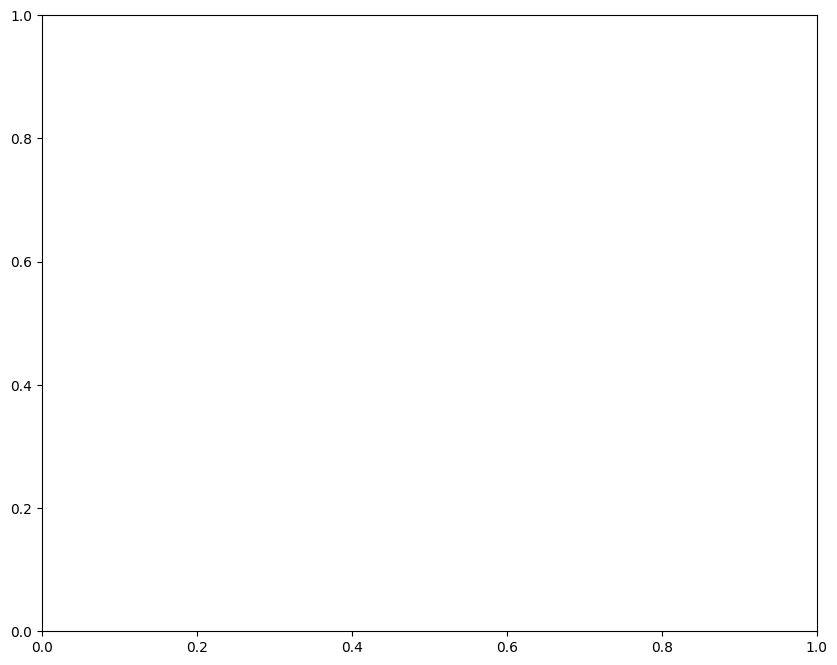

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax.bar(sim_df.index, sim_df['y'], color='lightgray')
ax.plot(cv_df.index, cv_df['CrostonClassic'], ls='--', label='Croston')
ax.set_ylabel('Value')
ax.set_xlabel('Time steps')
ax.legend(loc='best')
plt.xlim(40, 100)

plt.tight_layout()

# Croston Optimizado

In [ ]:
from statsforecast.models import CrostonOptimized

In [ ]:
models = [CrostonOptimized()]

sf = StatsForecast(
    df = sim_df,
    models = models,
    freq = 'H',
    n_jobs = -1
)

cv_df = sf.cross_validation(
    df = sim_df,
    h = 1,
    step_size = 1,
    n_windows = 50
)

cv_df.index = np.arange(50, 100, 1)

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))

ax.bar(sim_df.index, sim_df['y'], color = 'lightgray')
ax.plot(cv_df.index, cv_df['CrostonOptimized'], ls = '--', label = 'Croston (Optimized)')
ax.set_ylabel('Value')
ax.set_xlabel('Time steps')
ax.legend(loc = 'best')
plt.xlim(40, 100)

plt.tight_layout()

# ADIDA

In [ ]:
agg_sim_df = sim_df['y'].rolling(window = 5, step = 5).sum()
agg_sim_df.reset_index(drop = True)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrow)

In [ ]:
# Variables
stockCost = 0.25                # in [0, inf]; is opportunity costs
opportunityCost = 1 - stockCost # in [0, inf]; is stock-keeping cost
nt                              # lenght of time series
yt                              # actual demand at time t
ft                              # corresponding forecast